In [41]:
import torch
from typing import List
import os
import sys

from os.path import join

base_dir = "../"
sys.path.insert(0, base_dir)

from stable_diffusion2.utils.utils import (
    check_device,
    get_memory_status,
    to_pil,
    save_image_grid,
    show_image_grid,
)
from stable_diffusion2.constants import ModelsPathTree
from stable_diffusion2 import StableDiffusion
from stable_diffusion2.model.clip_text_embedder import CLIPTextEmbedder

EMBEDDED_PROMPTS_DIR = os.path.abspath("./input/embedded_prompts/")
NULL_PROMPT = ""
PROMPTS = "An old photo of a computer scientist"
NUM_IMAGES = 16
SEED = 2982
NOISE_MULTIPLIER = 0.01

os.makedirs(EMBEDDED_PROMPTS_DIR, exist_ok=True)
# DEVICE = input("Set device: 'cuda:i' or 'cpu'")
DEVICE = "cuda:0"
DEVICE = check_device(DEVICE)
pt = ModelsPathTree(base_directory=base_dir)

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.


In [42]:
def embed_and_save_prompts(prompts: list, null_prompt=NULL_PROMPT):
    null_prompt = null_prompt
    prompts = prompts

    clip_text_embedder = CLIPTextEmbedder(device=check_device())
    clip_text_embedder.load_submodels(**pt.embedder_submodels)

    null_cond = clip_text_embedder(null_prompt)
    torch.save(null_cond, join(EMBEDDED_PROMPTS_DIR, "null_cond.pt"))
    print(
        "Null prompt embedding saved at: ",
        f"{join(EMBEDDED_PROMPTS_DIR, 'null_cond.pt')}",
    )

    embedded_prompts = clip_text_embedder(prompts)
    torch.save(embedded_prompts, join(EMBEDDED_PROMPTS_DIR, "embedded_prompts.pt"))

    print(
        "Prompts embeddings saved at: ",
        f"{join(EMBEDDED_PROMPTS_DIR, 'embedded_prompts.pt')}",
    )

    get_memory_status()
    clip_text_embedder.to("cpu")
    del clip_text_embedder
    torch.cuda.empty_cache()
    get_memory_status()

    return embedded_prompts, null_cond

In [46]:
embedded_prompts, null_prompt = embed_and_save_prompts(PROMPTS)
embedding = embedded_prompts

INFO: `device` is None. Falling back to current device.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Null prompt embedding saved at:  c:\Users\igor-\.cloned\kcg-ml-sd1p4\notebooks\input\embedded_prompts\null_cond.pt
Prompts embeddings saved at:  c:\Users\igor-\.cloned\kcg-ml-sd1p4\notebooks\input\embedded_prompts\embedded_prompts.pt
Total: 12287 MiB
Free: 5140 MiB
Used: 7147 MiB
Total: 12287 MiB
Free: 5140 MiB
Used: 7147 MiB


In [47]:
# check the shape of the embedded prompts
embedding_shape = tuple(embedded_prompts.shape)
embedding_shape

(1, 77, 768)

In [48]:
# check mean and std to use the same for the noise generation
# one idea is to use one distribution per position (in the 77 positions)
# in this case we would check the mean and std along dimension 2
# embedded_prompts.mean(dim=2), embedded_prompts.std(dim=2)
embedding_mean, embedding_std = embedded_prompts.mean(), embedded_prompts.std()
embedding_mean, embedding_std

(tensor(-0.1092, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0230, device='cuda:0', grad_fn=<StdBackward0>))

In [74]:
embedded_prompts.mean(dim=2), embedded_prompts.std(dim=2)

(tensor([[-0.1049, -0.1113, -0.1070, -0.1129, -0.1143, -0.1122, -0.1080, -0.1133,
          -0.1141, -0.1104, -0.1105, -0.1105, -0.1105, -0.1104, -0.1103, -0.1103,
          -0.1102, -0.1101, -0.1100, -0.1100, -0.1099, -0.1098, -0.1097, -0.1096,
          -0.1096, -0.1095, -0.1095, -0.1095, -0.1094, -0.1094, -0.1093, -0.1093,
          -0.1093, -0.1092, -0.1092, -0.1091, -0.1091, -0.1090, -0.1090, -0.1090,
          -0.1090, -0.1089, -0.1088, -0.1088, -0.1088, -0.1087, -0.1087, -0.1086,
          -0.1086, -0.1086, -0.1085, -0.1085, -0.1084, -0.1084, -0.1084, -0.1084,
          -0.1083, -0.1084, -0.1084, -0.1083, -0.1084, -0.1083, -0.1083, -0.1083,
          -0.1083, -0.1083, -0.1082, -0.1082, -0.1083, -0.1083, -0.1083, -0.1082,
          -0.1083, -0.1083, -0.1082, -0.1082, -0.1083]], device='cuda:0',
        grad_fn=<MeanBackward1>),
 tensor([[1.5788, 1.0201, 1.0000, 0.9880, 0.9781, 1.0119, 1.0070, 0.9882, 1.0041,
          1.0137, 1.0121, 1.0118, 1.0118, 1.0116, 1.0115, 1.0112, 1.0109

In [68]:
differences = []
differences_means = []
differences_stds = []
dot_products = []
for i, row in enumerate(embedded_prompts.squeeze()):
    if i == 0:
        continue
    diff = row - embedded_prompts.squeeze()[0]
    differences.append(diff)
    differences_means.append(diff.mean())
    differences_stds.append(diff.std())
    dot_products.append(torch.dot(row, embedded_prompts.squeeze()[0]))

In [69]:
differences = torch.stack(differences)
differences_means = torch.stack(differences_means)
differences_stds = torch.stack(differences_stds)
dot_products = torch.stack(dot_products)

In [80]:
differences_means

tensor([-0.0064, -0.0021, -0.0080, -0.0094, -0.0073, -0.0031, -0.0084, -0.0092,
        -0.0055, -0.0056, -0.0056, -0.0055, -0.0055, -0.0054, -0.0054, -0.0053,
        -0.0052, -0.0051, -0.0050, -0.0050, -0.0049, -0.0048, -0.0047, -0.0047,
        -0.0046, -0.0046, -0.0045, -0.0045, -0.0044, -0.0044, -0.0044, -0.0044,
        -0.0043, -0.0042, -0.0042, -0.0041, -0.0041, -0.0041, -0.0041, -0.0040,
        -0.0040, -0.0039, -0.0039, -0.0039, -0.0038, -0.0038, -0.0037, -0.0037,
        -0.0036, -0.0036, -0.0036, -0.0035, -0.0035, -0.0034, -0.0035, -0.0034,
        -0.0034, -0.0034, -0.0034, -0.0034, -0.0034, -0.0034, -0.0034, -0.0033,
        -0.0034, -0.0033, -0.0033, -0.0033, -0.0033, -0.0034, -0.0033, -0.0033,
        -0.0034, -0.0033, -0.0033, -0.0033], device='cuda:0',
       grad_fn=<StackBackward0>)

In [81]:
differences_stds

tensor([2.0660, 2.0028, 1.9100, 1.9222, 2.0593, 1.9888, 1.8481, 1.7981, 1.8303,
        1.8339, 1.8377, 1.8405, 1.8437, 1.8459, 1.8473, 1.8494, 1.8503, 1.8519,
        1.8533, 1.8538, 1.8556, 1.8562, 1.8574, 1.8589, 1.8596, 1.8615, 1.8624,
        1.8639, 1.8659, 1.8668, 1.8690, 1.8699, 1.8708, 1.8721, 1.8723, 1.8739,
        1.8747, 1.8755, 1.8773, 1.8780, 1.8793, 1.8800, 1.8807, 1.8815, 1.8815,
        1.8821, 1.8818, 1.8831, 1.8834, 1.8849, 1.8853, 1.8864, 1.8873, 1.8876,
        1.8894, 1.8891, 1.8902, 1.8910, 1.8912, 1.8924, 1.8928, 1.8939, 1.8946,
        1.8952, 1.8959, 1.8967, 1.8982, 1.8998, 1.9014, 1.9028, 1.9031, 1.9047,
        1.9059, 1.9072, 1.9090, 1.9022], device='cuda:0',
       grad_fn=<StackBackward0>)

In [82]:
dot_products

tensor([-272.9704, -190.3536,  -59.6440,  -85.0620, -268.7256, -163.3396,
          29.6781,  111.7503,   74.2103,   67.8705,   62.3084,   58.3523,
          53.6815,   50.4609,   48.1476,   45.0236,   43.6444,   41.4126,
          39.6152,   38.9197,   36.4972,   36.0282,   34.3712,   32.5539,
          31.8142,   29.2055,   28.0926,   25.9812,   23.3427,   22.1538,
          18.8028,   17.6219,   16.3496,   14.5531,   14.4897,   12.2564,
          11.4087,   10.3517,    7.7931,    6.9899,    5.1003,    4.2466,
           3.3235,    2.1726,    2.3566,    1.5624,    2.2325,    0.9472,
           1.0603,   -0.7324,   -0.9848,   -2.5551,   -3.5039,   -3.7413,
          -6.3613,   -5.6165,   -7.2600,   -7.9833,   -8.1477,  -10.1057,
         -10.5560,  -12.0845,  -12.7856,  -13.6997,  -14.7217,  -15.5201,
         -17.5132,  -19.6504,  -21.8173,  -23.6373,  -23.8866,  -26.2850,
         -28.2129,  -29.9665,  -32.3471,  -23.7477], device='cuda:0',
       grad_fn=<StackBackward0>)

In [83]:
# generate noise and add to the embedded prompt
generator = torch.Generator(device=DEVICE).manual_seed(SEED)
noise = torch.normal(
    mean=embedding_mean.item(),
    std=embedding_std.item(),
    size=embedding_shape,
    device=DEVICE,
    generator=generator,
)
noise.shape

torch.Size([1, 77, 768])

In [84]:
embedding_e = embedded_prompts + 0.1 * noise

In [85]:
get_memory_status()

Total: 12287 MiB
Free: 5140 MiB
Used: 7147 MiB


In [86]:
%%capture
sd = StableDiffusion(device=DEVICE)
sd.quick_initialize().load_autoencoder(**pt.autoencoder).load_decoder(**pt.decoder)
sd.model.load_unet(**pt.unet)

In [87]:
get_memory_status()

Total: 12287 MiB
Free: 5140 MiB
Used: 7147 MiB


In [88]:
image = sd.generate_images_from_embeddings(
    seed=SEED, embedded_prompt=embedded_prompts, null_prompt=null_prompt
)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

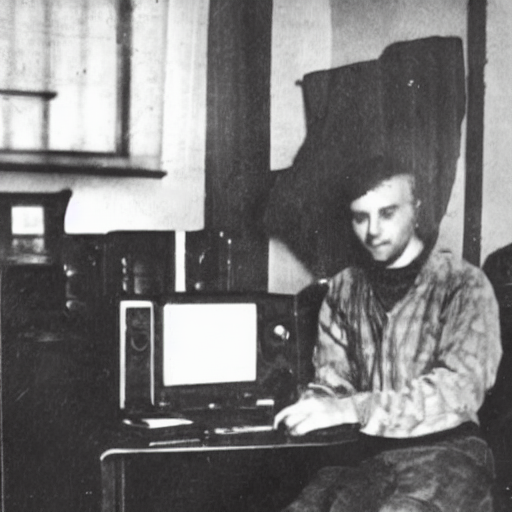

In [89]:
to_pil(image[0])

In [90]:
image_e = sd.generate_images_from_embeddings(
    seed=SEED, embedded_prompt=embedding_e, null_prompt=null_prompt
)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

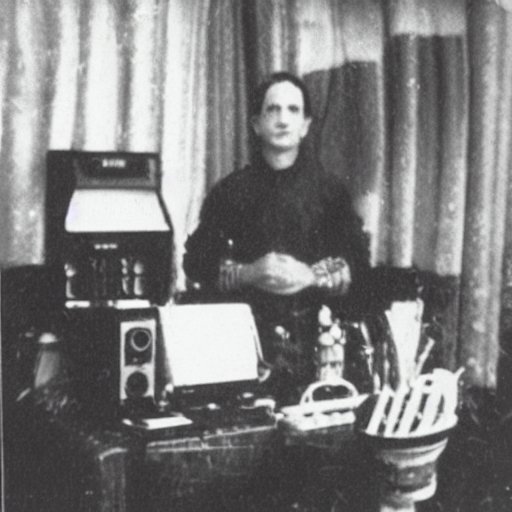

In [91]:
to_pil(image_e[0])

In [92]:
def generate_images_from_disturbed_embeddings(
    sd: StableDiffusion,
    embedded_prompt: torch.Tensor,
    device=DEVICE,
    seed=SEED,
    num_images=NUM_IMAGES,
    noise_multiplier=NOISE_MULTIPLIER,
):
    generator = torch.Generator(device=device).manual_seed(seed)

    embedding_mean, embedding_std = embedded_prompt.mean(), embedded_prompt.std()
    embedding_shape = tuple(embedded_prompts.shape)

    # noise = torch.normal(
    #     mean=embedding_mean.item(),
    #     std=embedding_std.item(),
    #     size=embedding_shape,
    #     device=device,
    #     generator=generator,
    # )
    # test with standard normal distribution
    noise = torch.normal(
        mean=0.0,
        std=1.0,
        size=embedding_shape,
        device=device,
        generator=generator,
    )

    for i in range(0, num_images):
        embedding_e = embedded_prompt + (i * noise_multiplier) * noise
        image_e = sd.generate_images_from_embeddings(
            seed=seed, embedded_prompt=embedding_e, null_prompt=null_prompt
        )
        yield image_e[0]

In [37]:
image_generator = generate_images_from_disturbed_embeddings(sd, embedded_prompts)

In [38]:
images = list(image_generator)

HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

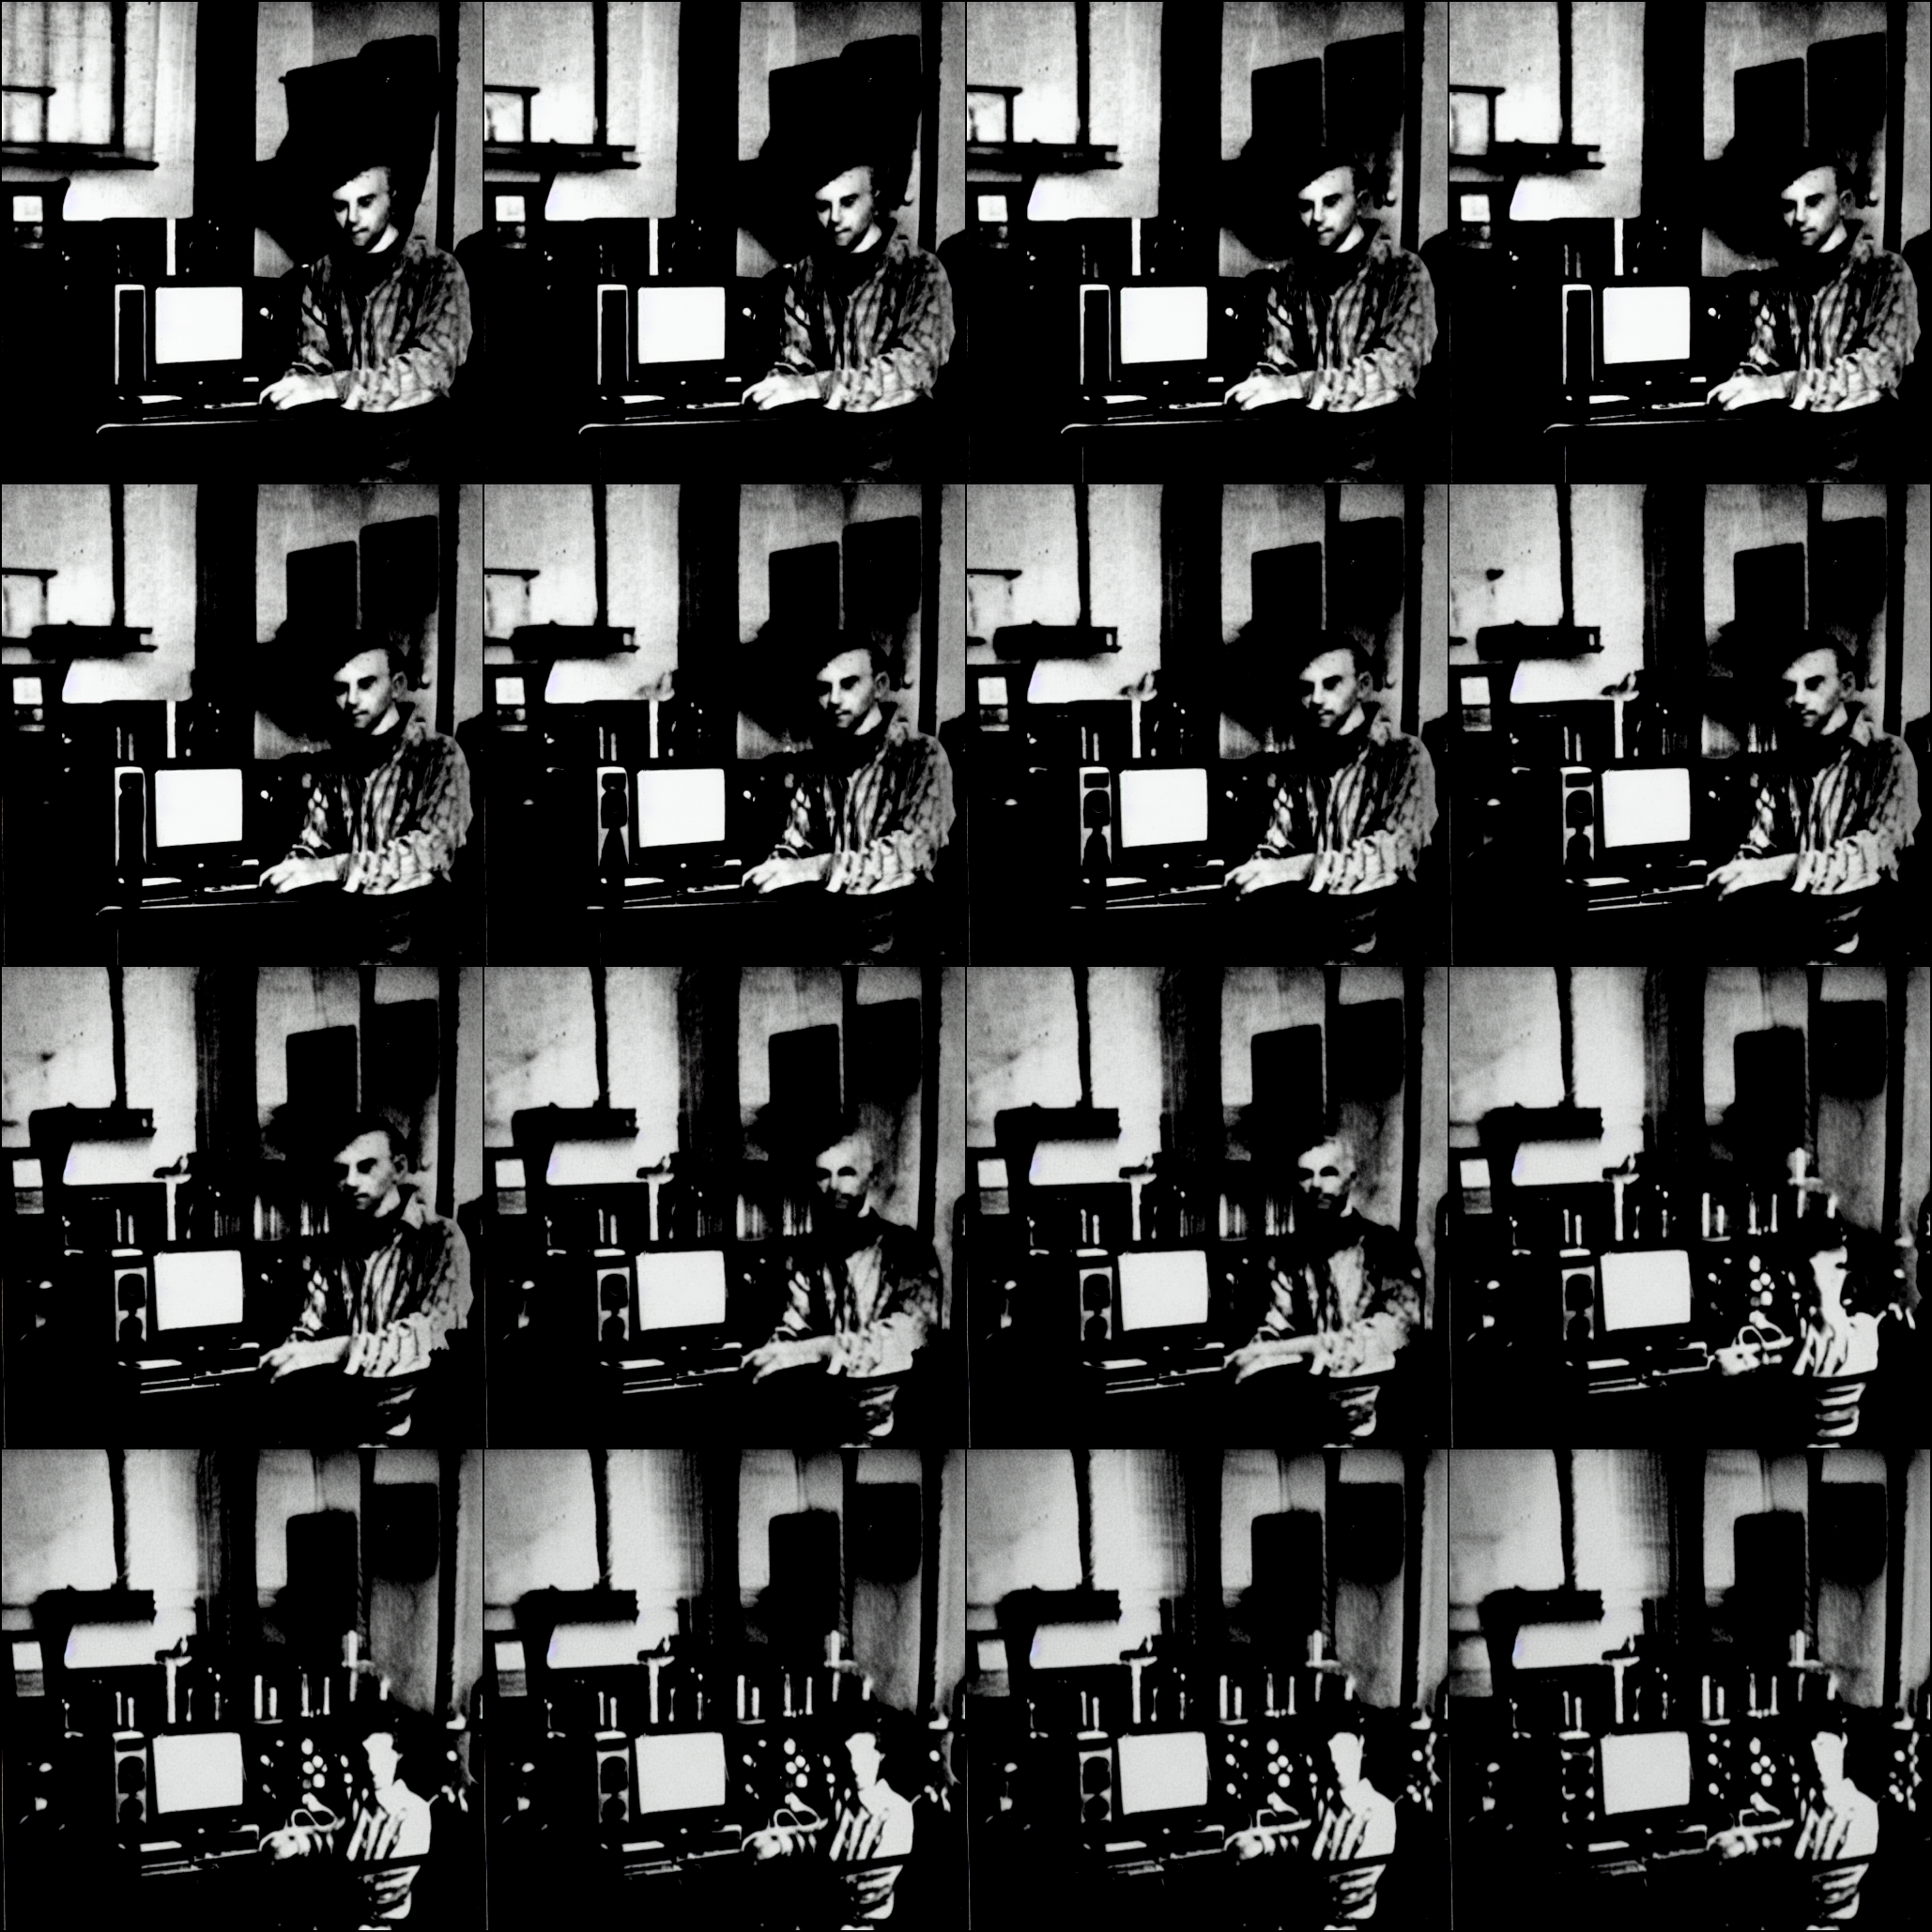

In [39]:
import math

show_image_grid(images, nrow=int(math.log(NUM_IMAGES, 2)))